# **Photos To Monet**

In [1]:
import glob
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as L
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from pytorch_lightning.utilities import CombinedLoader
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image
_ = L.seed_everything(0, workers=True)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Data Preprocessing 

In [2]:
def show_img(img_tensor, nrow, title=""):
    img_tensor = img_tensor.detach().cpu() * 0.5 + 0.5   # detach: non-trainable, *0.5 + 0.5: move from [-1,1] to [0,1]
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0) # rearranges from (C,H,W) from (H, W, C)
    plt.figure(figsize=(10, 7)) # create new figue
    plt.imshow(img_grid)  # display grid
    plt.axis("off")   # hide the axis
    plt.title(title)
    plt.show()

**Augmenting the images.**

Before loading the datasets, we define CustomTransform for image augmentation. This improves learning by introducing more variety in the images during training instead of learning from the same set of images, especially when we only have 300 Monet paintings.

In [3]:
class CustomTransform(object):
    def __init__(self, load_dim=286, target_dim=256):
        self.transform_train = T.Compose([
            T.Resize((load_dim, load_dim), antialias=True),   # what the hell?????? 
            T.RandomCrop((target_dim, target_dim)),
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.2, contrast=0.2,   # Randomly changes brightness, contrast, saturation, and hue
                          saturation=0.2, hue=0.1),
        ])
        self.transform = T.Resize((target_dim, target_dim), antialias=True)   # antialias = true => no randomness
    def __call__(self, img, stage):
        if stage == "fit":
            img = self.transform_train(img)
        else:
            img = self.transform(img)
        return img * 2 - 1

**Storing dataset**

In [4]:
class CustomDataset(Dataset):
    def __init__(self, filenames, transform, stage):
        self.filenames = filenames
        self.transform = transform
        self.stage = stage
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img = read_image(img_name) / 255.0    # normalization
        return self.transform(img, stage=self.stage)

**Iterating through the datasets**

To prepare the datasets, we load them into DataLoader separately, which can then iterate through the datasets as needed. Because the training dataset contains both the Monet paintings and photos, we pass both dataloaders into CombinedLoader for training. 

In [5]:
DEBUG = False

DM_CONFIG = {    
    "monet_dir": os.path.join("/kaggle/input/gan-getting-started/monet_jpg", "*.jpg"),
    "photo_dir": os.path.join("/kaggle/input/gan-getting-started/photo_jpg", "*.jpg"),
    
    "loader_config": {
        "num_workers": os.cpu_count(),
        "pin_memory": torch.cuda.is_available(),   # If True, the DataLoader uses page-locked memory (pinned memory) for faster data transfer from CPU to GPU.
    },
    "sample_size": 5,
    "batch_size": 64 if not DEBUG else 1,
}

In [6]:
class CustomDataModule(L.LightningDataModule):
    def __init__(
        self,
        monet_dir,
        photo_dir, 
        loader_config,
        sample_size,
        batch_size,
    ):
        super().__init__()
        self.loader_config = loader_config
        self.sample_size = sample_size
        self.batch_size = batch_size       
            
        # store file paths
        self.monet_filenames = sorted(glob.glob(monet_dir))
        self.photo_filenames = sorted(glob.glob(photo_dir))
        
        # define transformations for image augmentation
        self.transform = CustomTransform()
        
    def setup(self, stage):
        if stage == "fit":
            self.train_monet = CustomDataset(self.monet_filenames, self.transform, stage)
            self.train_photo = CustomDataset(self.photo_filenames, self.transform, stage)
            
        if stage in ["fit", "test", "predict"]:
            # to be used for test and prediction datasets as well
            self.valid_photo = CustomDataset(self.photo_filenames, self.transform, None)
            
    def train_dataloader(self):
        loader_config = {
            "shuffle": True,
            "drop_last": True,
            "batch_size": self.batch_size,
            **self.loader_config,
        }
        loader_monet = DataLoader(self.train_monet, **loader_config)
        loader_photo = DataLoader(self.train_photo, **loader_config)
        loaders = {"monet": loader_monet, "photo": loader_photo}
        return CombinedLoader(loaders, mode="max_size_cycle")
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_photo,
            batch_size=self.sample_size,
            **self.loader_config,
        )
    
    def test_dataloader(self):
        return self.val_dataloader()
    
    def predict_dataloader(self):
        return DataLoader(
            self.valid_photo, 
            batch_size=self.batch_size,   # similar to val_dataloader, just change sample_size by batch_size
            **self.loader_config,
        )

We check that the datamodule defined is working as intended by visualizing samples of the images below.

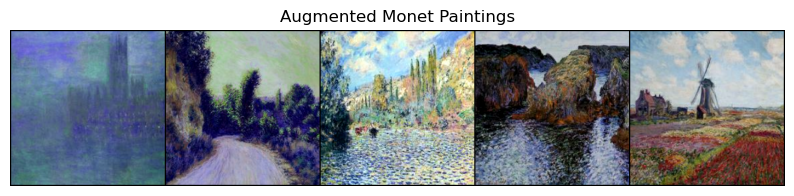

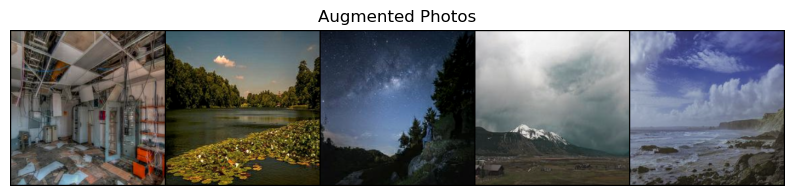

In [7]:
dm_sample = CustomDataModule(batch_size=5, **{k: v for k, v in DM_CONFIG.items() if k != "batch_size"})
dm_sample.setup("fit")   # initialize => setup => create dataloader => next => show_img
train_loader = dm_sample.train_dataloader()
imgs = next(iter(train_loader))   # Common way to get the first element of a Dataloader object
show_img(imgs["monet"], nrow=5, title="Augmented Monet Paintings")
show_img(imgs["photo"], nrow=5, title="Augmented Photos")

# Building GAN Architecture

**U-Net Generator**

A common architecture for the CycleGAN generator is the U-Net. U-Net is a network which consists of a sequence of downsampling blocks followed by a sequence of upsampling blocks, giving it the U-shaped architecture. In the upsampling path, we concatenate the outputs of the upsampling blocks and the outputs of the downsampling blocks symmetrically. This can be seen as a kind of skip connection, facilitating information flow in deep networks and reducing the impact of vanishing gradients.

**ResNet generator**

Similar to the U-Net architecture, the ResNet generator consists of the downsampling path and upsampling path. The difference is that the ResNet generator does not have the long skip connections from the concatenations of outputs. Instead, the ResNet generator uses residual blocks between the two paths. These residual blocks have short skip connections where the original input is added to the output.

**Downsampling blocks**

The downsampling blocks use convolution layers to increase the number of feature maps while reducing the dimensions of the 2D image.

In [8]:
class Downsampling(nn.Module):   # conv2d (end block) => Norm/LeakyRelu
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        norm=True,
        lrelu=True,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=not norm),
        )
        if norm:
            self.block.append(nn.InstanceNorm2d(out_channels, affine=True))
        if lrelu is not None:
            self.block.append(nn.LeakyReLU(0.2, True) if lrelu else nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)

**Upsampling blocks**

On the other hand, the upsampling blocks contain transposed convolution layers, which combine the learned features to output an image with the original size.

In [9]:
class Upsampling(nn.Module):   # ConvTranspose => norm (end blcok) => dropout/None => Relu
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        output_padding=0,
        dropout=False,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                               kernel_size=kernel_size, stride=stride, 
                               padding=padding, output_padding=output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
        )
        if dropout:
            self.block.append(nn.Dropout(0.5))
        self.block.append(nn.ReLU(True))
        
    def forward(self, x):
        return self.block(x)

**Residual blocks**

As described above, the residual blocks have convolution layers where the original input is added to the output.

In [10]:
class ResBlock(nn.Module):   # (reflectionPad (relu=False) + Downsampling + )
    def __init__(self, in_channels, kernel_size=3, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(padding),
            Downsampling(in_channels, in_channels,
                         kernel_size=kernel_size, stride=1, padding=0, lrelu=False),
            nn.ReflectionPad2d(padding),
            Downsampling(in_channels, in_channels,
                         kernel_size=kernel_size, stride=1, padding=0, lrelu=None),
        )
        
    def forward(self, x):
        return x + self.block(x)

**Building the generator**

With the building blocks defined, we can now build our CycleGAN generator. For reference, the output size of each block is commented below.

In [11]:
class UNetGenerator(nn.Module):   # 
    def __init__(self, hid_channels, in_channels, out_channels):
        super().__init__()
        self.downsampling_path = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8), # 512x16x16
            Downsampling(hid_channels*8, hid_channels*8), # 512x8x8
            Downsampling(hid_channels*8, hid_channels*8), # 512x4x4
            Downsampling(hid_channels*8, hid_channels*8), # 512x2x2
            Downsampling(hid_channels*8, hid_channels*8, norm=False), # 512x1x1, instance norm does not work on 1x1
        )
        self.upsampling_path = nn.Sequential(
            Upsampling(hid_channels*8, hid_channels*8, dropout=True), # (512+512)x2x2
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x4x4
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), # (512+512)x8x8
            Upsampling(hid_channels*16, hid_channels*8), # (512+512)x16x16
            Upsampling(hid_channels*16, hid_channels*4), # (256+256)x32x32
            Upsampling(hid_channels*8, hid_channels*2), # (128+128)x64x64
            Upsampling(hid_channels*4, hid_channels), # (64+64)x128x128
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        skips = []
        for down in self.downsampling_path:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])

        for up, skip in zip(self.upsampling_path, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        return self.feature_block(x)
    
class ResNetGenerator(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels, num_resblocks):
        super().__init__()
        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            Downsampling(in_channels, hid_channels,
                         kernel_size=7, stride=1, padding=0, lrelu=False), # 64x256x256
            Downsampling(hid_channels, hid_channels*2, kernel_size=3, lrelu=False), # 128x128x128
            Downsampling(hid_channels*2, hid_channels*4, kernel_size=3, lrelu=False), # 256x64x64
            *[ResBlock(hid_channels*4) for _ in range(num_resblocks)], # 256x64x64
            Upsampling(hid_channels*4, hid_channels*2, kernel_size=3, output_padding=1), # 128x128x128
            Upsampling(hid_channels*2, hid_channels, kernel_size=3, output_padding=1), # 64x256x256
            nn.ReflectionPad2d(3),
            nn.Conv2d(hid_channels, out_channels, kernel_size=7, stride=1, padding=0), # 3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.model(x)
    
def get_gen(gen_name, hid_channels, num_resblocks, in_channels=3, out_channels=3):
    if gen_name == "unet":
        return UNetGenerator(hid_channels, in_channels, out_channels)
    elif gen_name == "resnet":
        return ResNetGenerator(hid_channels, in_channels, out_channels, num_resblocks)
    else:
        raise NotImplementedError(f"Generator name '{gen_name}' not recognized.")

**Patch Gan Generator**

Unlike conventional networks that output a single probability of the input image being real or fake, CycleGAN uses the PatchGAN discriminator that outputs a matrix of values. Intuitively, each value of the output matrix checks the corresponding portion of the input image. Values closer to 1 indicate real classification and values closer to 0 indicate fake classification.

**Building the discriminator**

In general, the PatchGAN discriminator consists of a sequence of convolution layers, which can be built using the downsampling blocks defined earlier.

In [12]:
class Discriminator(nn.Module):
    def __init__(self, hid_channels, in_channels=3):
        super().__init__()
        self.block = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), # 64x128x128
            Downsampling(hid_channels, hid_channels*2), # 128x64x64
            Downsampling(hid_channels*2, hid_channels*4), # 256x32x32
            Downsampling(hid_channels*4, hid_channels*8, stride=1), # 512x31x31
            nn.Conv2d(hid_channels*8, 1, kernel_size=4, padding=1), # 1x30x30
        )
        
    def forward(self, x):
        return self.block(x)

**Image buffer**

The original CycleGAN implementation updates the discriminator using a history of generated images instead of the latest images generated. This is done by setting up an image buffer that stores previously generated images. With probability 0.5, each newly generated image is swapped with a previously generated image stored in the buffer. This stabilizes training by giving the discriminator access to past information.

In [13]:
class ImageBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        if self.buffer_size > 0:
            # the current capacity of the buffer
            self.curr_cap = 0
            # initialize buffer as empty list
            self.buffer = []
    
    def __call__(self, imgs):
        # the buffer is not used
        if self.buffer_size == 0:
            return imgs
        
        return_imgs = []
        for img in imgs:
            img = img.unsqueeze(dim=0)
            
            # fill buffer to maximum capacity
            if self.curr_cap < self.buffer_size:
                self.curr_cap += 1
                self.buffer.append(img)
                return_imgs.append(img)
            else:
                p = np.random.uniform(low=0., high=1.)
                
                # swap images between input and buffer with probability 0.5
                if p > 0.5:
                    idx = np.random.randint(low=0, high=self.buffer_size)
                    tmp = self.buffer[idx].clone()
                    self.buffer[idx] = img
                    return_imgs.append(tmp)
                else:
                    return_imgs.append(img)
        return torch.cat(return_imgs, dim=0)

**CycleGan**

With the generator and discriminator architectures defined, we can now build CycleGAN, which consists of two generators and two discriminators:

* Generator for photo-to-Monet translation (gen_PM).
* Generator for Monet-to-photo translation (gen_MP).
* Discriminator for Monet paintings (disc_M).
* Discriminator for photos (disc_P).
We use the Adam optimizer for model training. To optimize the parameters, we need to define the loss functions:

* **Discriminator loss**:- For real images fed into the discriminator, the output matrix is compared against a matrix of 1s using the mean squared error. For fake images, the output matrix is compared against a matrix of 0s. This suggests that to minimize loss, the perfect discriminator outputs a matrix of 1s for real images and a matrix of 0s for fake images.
* **Generator loss:-** This is composed of three different loss functions below.
     *          *Adversarial loss* :-Fake images are fed into the discriminator and the output matrix is compared against a matrix of 1s using the mean squared error. To minimize loss, the generator needs to 'fool' the discriminator into thinking that the fake images are real and output a matrix of 1s.
    *         *Identity loss*:- When a Monet painting is fed into the photo-to-Monet generator, we should get back the same Monet painting because nothing needs to be transformed. The same applies for photos fed into the Monet-to-photo generator. To encourage identity mapping, the difference in pixel values between the input image and generated image is measured using the l1 loss.
    *         *Cycle loss* When a Monet painting is fed into the Monet-to-photo generator, and the generated image is fed back into the photo-to-Monet generator, it should transform back into the original Monet painting. The same applies for photos passed to the two generators to get back the original photos. To preserve information throughout this cycle, the l1 loss is used to measure the difference between the original image and the reconstructed image.

**Building the CycleGAN model**

In [14]:
MODEL_CONFIG = {
    # the type of generator, and the number of residual blocks if ResNet generator is used
    "gen_name": "unet", # types: 'unet', 'resnet'
    "num_resblocks": 6,
    # the number of filters in the first layer for the generators and discriminators
    "hid_channels": 64,
    # using DeepSpeed's FusedAdam (currently GPU only) is slightly faster
    "optimizer": torch.optim.Adam,
    # the learning rate and beta parameters for the Adam optimizer
    "lr": 1e-5,
    "betas": (0.5, 0.999),
    # the weights used in the identity loss and cycle loss
    "lambda_idt": 0,
    "lambda_cycle": (10, 10), # (MPM direction, PMP direction)
    # the size of the buffer that stores previously generated images
    "buffer_size": 100,
    # the number of epochs for training
    "num_epochs": 5 if not DEBUG else 70,
    # the number of epochs before starting the learning rate decay
    "decay_epochs": 70 if not DEBUG else 70,
}

In [15]:
class CycleGAN(L.LightningModule):
    def __init__(
        self,
        gen_name,
        num_resblocks,
        hid_channels,
        optimizer,
        lr,
        betas,
        lambda_idt,
        lambda_cycle,
        buffer_size,
        num_epochs,
        decay_epochs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.optimizer = optimizer
        self.automatic_optimization = False
        
        # define generators and discriminators
        self.gen_PM = get_gen(gen_name, hid_channels, num_resblocks)
        self.gen_MP = get_gen(gen_name, hid_channels, num_resblocks)
        self.disc_M = Discriminator(hid_channels)
        self.disc_P = Discriminator(hid_channels)
        
        # initialize buffers to store fake images
        self.buffer_fake_M = ImageBuffer(buffer_size)
        self.buffer_fake_P = ImageBuffer(buffer_size)
        
    def forward(self, img):
        return self.gen_PM(img)   
            
    def init_weights(self):
        def init_fn(m):
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
        
        for net in [self.gen_PM, self.gen_MP, self.disc_M, self.disc_P]:
            net.apply(init_fn)
        
    def setup(self, stage):
        if stage == "fit":
            # self.init_weights()
            print("Model initialized.")
            
    def get_lr_scheduler(self, optimizer):
        def lr_lambda(epoch):
            len_decay_phase = self.hparams.num_epochs - self.hparams.decay_epochs + 1.0
            curr_decay_step = max(0, epoch - self.hparams.decay_epochs + 1.0)
            val = 1.0 - curr_decay_step / len_decay_phase
            return max(0.0, val)
        
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    
    def configure_optimizers(self):
        opt_config = {
            "lr": self.hparams.lr,
            "betas": self.hparams.betas,
        }
        opt_gen = self.optimizer(
            list(self.gen_PM.parameters()) + list(self.gen_MP.parameters()),
            **opt_config,
        )
        opt_disc = self.optimizer(
            list(self.disc_M.parameters()) + list(self.disc_P.parameters()),
            **opt_config,
        )
        optimizers = [opt_gen, opt_disc]
        schedulers = [self.get_lr_scheduler(opt) for opt in optimizers]
        return optimizers, schedulers
        
    def adv_criterion(self, y_hat, y):
        return F.mse_loss(y_hat, y)
    
    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)
    
    def get_adv_loss(self, fake, disc):
        fake_hat = disc(fake)
        real_labels = torch.ones_like(fake_hat)
        adv_loss = self.adv_criterion(fake_hat, real_labels)
        return adv_loss
    
    def get_idt_loss(self, real, idt, lambda_cycle):
        idt_loss = self.recon_criterion(idt, real)
        return 0
        # return self.hparams.lambda_idt * lambda_cycle * idt_loss
    
    def get_cycle_loss(self, real, recon, lambda_cycle):
        cycle_loss = self.recon_criterion(recon, real)
        return lambda_cycle * cycle_loss
    
    def get_gen_loss(self):
        # calculate adversarial loss
        adv_loss_PM = self.get_adv_loss(self.fake_M, self.disc_M)
        adv_loss_MP = self.get_adv_loss(self.fake_P, self.disc_P)
        total_adv_loss = adv_loss_PM + adv_loss_MP
        
        # calculate identity loss
        lambda_cycle = self.hparams.lambda_cycle
        idt_loss_MM = self.get_idt_loss(self.real_M, self.idt_M, lambda_cycle[0])
        idt_loss_PP = self.get_idt_loss(self.real_P, self.idt_P, lambda_cycle[1])
        total_idt_loss = idt_loss_MM + idt_loss_PP
        
        # calculate cycle loss
        cycle_loss_MPM = self.get_cycle_loss(self.real_M, self.recon_M, lambda_cycle[0])
        cycle_loss_PMP = self.get_cycle_loss(self.real_P, self.recon_P, lambda_cycle[1])
        total_cycle_loss = cycle_loss_MPM + cycle_loss_PMP
        
        # combine losses
        gen_loss = total_adv_loss + total_idt_loss + total_cycle_loss
        return gen_loss
    
    def get_disc_loss(self, real, fake, disc):
        # calculate loss on real images
        real_hat = disc(real)
        real_labels = torch.ones_like(real_hat)
        real_loss = self.adv_criterion(real_hat, real_labels)
        
        # calculate loss on fake images
        fake_hat = disc(fake.detach())
        fake_labels = torch.zeros_like(fake_hat)
        fake_loss = self.adv_criterion(fake_hat, fake_labels)
        
        # combine losses
        disc_loss = (fake_loss + real_loss) * 0.5
        return disc_loss
    
    def get_disc_loss_M(self):
        fake_M = self.buffer_fake_M(self.fake_M)
        return self.get_disc_loss(self.real_M, fake_M, self.disc_M)
    
    def get_disc_loss_P(self):
        fake_P = self.buffer_fake_P(self.fake_P)
        return self.get_disc_loss(self.real_P, fake_P, self.disc_P)
    
    def training_step(self, batch, batch_idx):
        self.real_M = batch["monet"]
        self.real_P = batch["photo"]
        opt_gen, opt_disc = self.optimizers()

        # generate fake images
        self.fake_M = self.gen_PM(self.real_P)
        self.fake_P = self.gen_MP(self.real_M)
        
        # generate identity images
        self.idt_M = self.gen_PM(self.real_M)
        self.idt_P = self.gen_MP(self.real_P)
        
        # reconstruct images
        self.recon_M = self.gen_PM(self.fake_P)
        self.recon_P = self.gen_MP(self.fake_M)
    
        # train generators
        self.toggle_optimizer(opt_gen)
        gen_loss = self.get_gen_loss()        
        opt_gen.zero_grad()
        self.manual_backward(gen_loss)
        opt_gen.step()
        self.untoggle_optimizer(opt_gen)
        
        # train discriminators
        self.toggle_optimizer(opt_disc)
        disc_loss_M = self.get_disc_loss_M()
        disc_loss_P = self.get_disc_loss_P()
        opt_disc.zero_grad()
        self.manual_backward(disc_loss_M)
        self.manual_backward(disc_loss_P)
        opt_disc.step()
        self.untoggle_optimizer(opt_disc)
        
        # record training losses
        metrics = {
            "gen_loss": gen_loss,
            "disc_loss_M": disc_loss_M,
            "disc_loss_P": disc_loss_P,
        }
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
        
    def validation_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "validate")
    
    def test_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "test")
        
    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def display_results(self, batch, batch_idx, stage):
        real_P = batch
        fake_M = self(real_P)
        
        if stage == "validate":
            title = f"Epoch {self.current_epoch+1}: Photo-to-Monet Translation"
        else:
            title = f"Sample {batch_idx+1}: Photo-to-Monet Translation"

        show_img(
            torch.cat([real_P, fake_M], dim=0),
            nrow=len(real_P),
            title=title,
        )
    
    def on_train_epoch_start(self):
        # record learning rates
        curr_lr = self.lr_schedulers()[0].get_last_lr()[0]
        self.log("lr", curr_lr, on_step=False, on_epoch=True, prog_bar=True)
        
    def on_train_epoch_end(self):
        # update learning rates
        for sch in self.lr_schedulers():
            sch.step()
        
        # print current state of epoch
        logged_values = self.trainer.progress_bar_metrics
        print(
            f"Epoch {self.current_epoch+1}",
            *[f"{k}: {v:.5f}" for k, v in logged_values.items()],
            sep=" - ",
        )
        
    def on_train_end(self):
        print("Training ended.")
        
    def on_predict_epoch_end(self):
        predictions = self.trainer.predict_loop.predictions
        num_batches = len(predictions)
        batch_size = predictions[0].shape[0]
        last_batch_diff = batch_size - predictions[-1].shape[0]
        print(f"Number of images generated: {num_batches*batch_size-last_batch_diff}.")

# Model Training 

In [16]:
TRAIN_CONFIG = {
    "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
    
    # train on 16-bit precision
    "precision": "16-mixed" if torch.cuda.is_available() else 32,
    
    # train on single GPU
    "devices": 1,
    
    # save checkpoint only for last epoch by default
    "enable_checkpointing": True,
    
    # disable logging for simplicity
    "logger": False,
    
    # the number of epochs for training (we limit the number of train/predict batches during debugging)
    "max_epochs": MODEL_CONFIG["num_epochs"],
    "limit_train_batches": 1.0 if not DEBUG else 2,
    "limit_predict_batches": 1.0 if not DEBUG else 5,
    
    # the maximum amount of time for training, in case we exceed run-time of 5 hours
    "max_time": {"hours": 20, "minutes": 0},
    
    # use a small subset of photos for validation/testing (we limit here for flexibility)
    "limit_val_batches": 1,
    "limit_test_batches": 5,
    
    # disable sanity check before starting the training routine
    "num_sanity_val_steps": 0,
    
    # the frequency to visualize the progress of adding Monet style
    "check_val_every_n_epoch": 1 if not DEBUG else 1,
}

In [17]:
# dm = CustomDataModule(**DM_CONFIG)
# model = CycleGAN(**MODEL_CONFIG)
# trainer = L.Trainer(**TRAIN_CONFIG)
# trainer.fit(model, datamodule=dm)

In [18]:
# trainer.save_checkpoint("./kaggle/working/checkpoint (4).ckpt")

In [19]:
pwd

'/kaggle/working'

In [20]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [21]:
cd /

/


In [22]:
from pytorch_lightning import LightningModule

# Load the saved model
model = CycleGAN.load_from_checkpoint("/kaggle/input/checkpoint4/pytorch/default/1/checkpoint (4).ckpt", **MODEL_CONFIG)


In [23]:
dm = CustomDataModule(**DM_CONFIG)
trainer = L.Trainer(**TRAIN_CONFIG)
# trainer.fit(model, datamodule=dm)

In [24]:
cd ./kaggle/working

/kaggle/working


**Testing the model on other sample photos**

Testing: 0it [00:00, ?it/s]

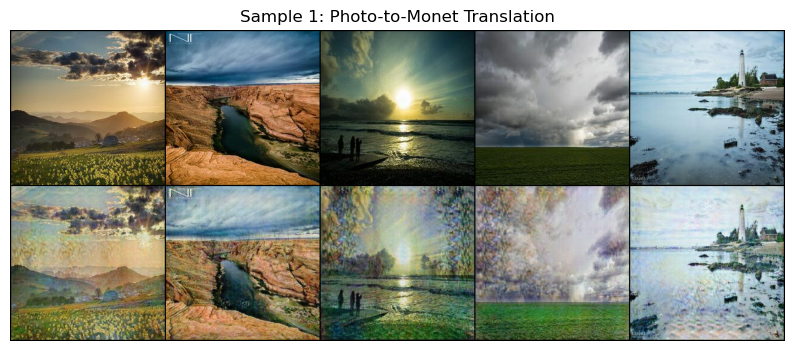

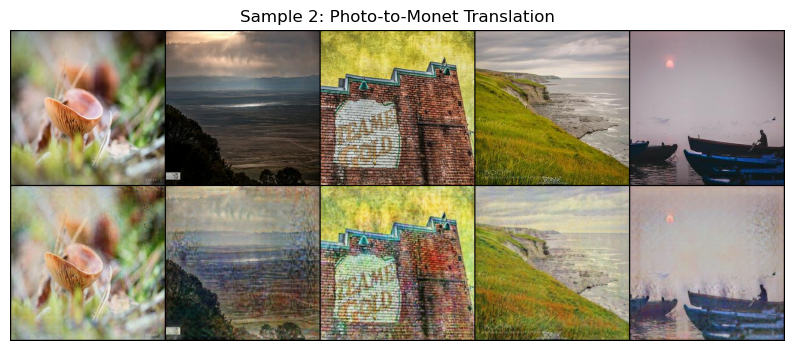

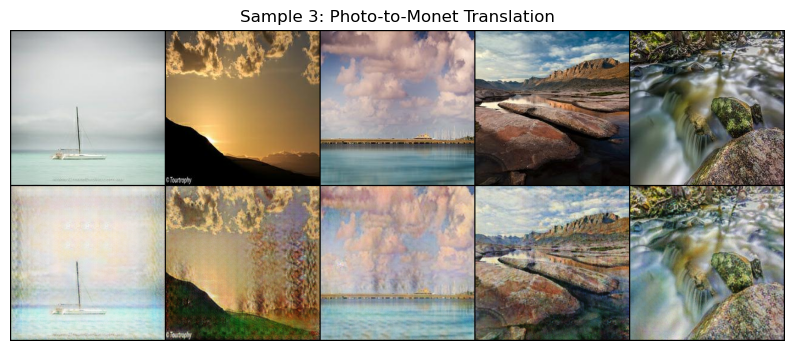

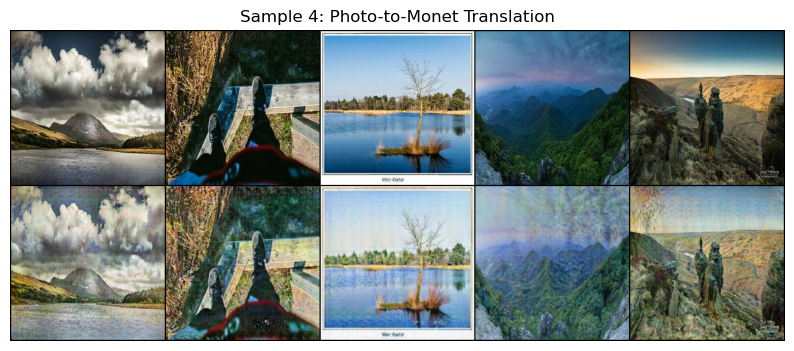

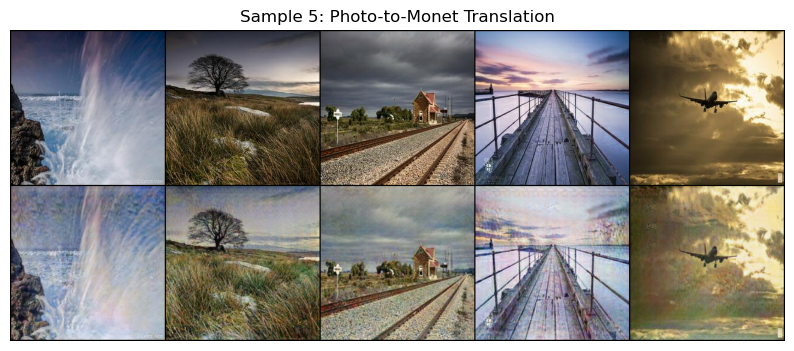

In [25]:
_ = trainer.test(model, datamodule=dm)

# Submission

Computing the predictions can be done by running the predict method to generate the Monet-style images given the input photos.

In [26]:
predictions = trainer.predict(model, datamodule=dm)

Predicting: 0it [00:00, ?it/s]

Number of images generated: 7038.


**Saving the generated images**

In [27]:
os.makedirs("../images", exist_ok=True)
idx = 0
for tensor in predictions:
    for monet in tensor:
        save_image(
            monet.float().squeeze() * 0.5 + 0.5, 
            fp=f"../images/{idx}.jpg",
        )
        idx += 1

shutil.make_archive("/kaggle/working/images", "zip", "/kaggle/images")

'/kaggle/working/images.zip'